### Init ###

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# now can import drive files as usual files with the path like
# /content/drive/My Drive/location_of_the_file


Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

DRIVE_INITIAL_PATH = r"/content/drive/My Drive/Data Mining"

RAW_RECIPES_PATH = r"data/RAW_recipes.csv"
RAW_INTERCATIONS_PATH = r"data/RAW_interactions.csv"
OUR_PP_RECIPES_PATH = r"data/our_pp_recipes.csv"
OUR_PP_INTERACTIONS_PATH = r"data/our_pp_interactions.csv"

DATE_FORMAT = "%Y-%m-%d"
RAW_RECIPES_DATE_COLUMNS = ["submitted"]
RAW_INTERCATIONS_DATE_COLUMNS = ["date"]

RAW_RECIPES_COL_NAMES_TRANSLATOR = {"id": "recipe_id"}
RAW_INTERACTIONS_COL_NAMES_TRANSLATOR = {}


TAGS_COLUMN_NAME = "tags"

TAGS_CATEGORIES_ADDITION = {"cuisine_tags": r"data/tags_categories/cuisine.csv",
                            "fish_tags": r"data/tags_categories/fish.csv",
                            "seafood_tags": r"data/tags_categories/seafood.csv",
                            "fruit_tags": r"data/tags_categories/fruit.csv",
                            "cheese_eggs_tags": r"data/tags_categories/cheese eggs.csv",
                            "grains_tags": r"data/tags_categories/grains.csv",
                            "lentils_tags": r"data/tags_categories/lentils.csv",
                            "meat_tags": r"data/tags_categories/meat.csv",
                            "vegetable_tags": r"data/tags_categories/vegetable.csv"}

def adapt_path_to_drive(original_path):
  return "/".join([DRIVE_INITIAL_PATH, original_path])

# for drive use
RAW_RECIPES_PATH = adapt_path_to_drive(RAW_RECIPES_PATH)
RAW_INTERCATIONS_PATH = adapt_path_to_drive(RAW_INTERCATIONS_PATH)
OUR_PP_RECIPES_PATH = adapt_path_to_drive(OUR_PP_RECIPES_PATH)
OUR_PP_INTERACTIONS_PATH = adapt_path_to_drive(OUR_PP_INTERACTIONS_PATH)

TAGS_CATEGORIES_ADDITION = {k:adapt_path_to_drive(v) for (k,v) in TAGS_CATEGORIES_ADDITION.items()}



### Date Formatter ###

In [ ]:
def format_date_column(df, column_to_format, date_format=DATE_FORMAT):
  df[column_to_format] = pd.to_datetime(df[column_to_format], format=date_format)
  return df

In [ ]:
# Recipe edition

def format_raw_recipes_date_cols(raw_recipes_df):
  for col_name in RAW_RECIPES_DATE_COLUMNS:
    raw_recipes_df = format_date_column(raw_recipes_df, col_name)
  return raw_recipes_df
  
# Interactions edition

def format_raw_interactions_date_cols(raw_interactions_df):
  for col_name in RAW_INTERCATIONS_DATE_COLUMNS:
    raw_interactions_df = format_date_column(raw_interactions_df, col_name)
  return raw_interactions_df

#Reality Checker#

how to use:
1. load dataframe to use to df variable
2. if we want to check column named col_name we do the following:

  a. reality_checker = RealityChecker(df, col_name)
  
  b. reality_checker.preform_check() / reality_checker.preform_check(bins=20)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import  display, HTML
import itertools

class RealityChecker:
    def __init__(self, df, col_name):
        self.df = df
        self.col_name = col_name
        self.series = df[col_name]
        self.values_type = type(self.series.values[0])

    def change_column(self, new_col_name):
        self.col_name = new_col_name
        self.series = self.df[new_col_name]
        self.values_type = type(self.series.values[0])

    def show_table(self, col1_name, col2_name, general_col_name="recipe_id"): # shows intersections table between 2 cols
        table_data = self.df.groupby([col1_name, col2_name])[general_col_name].count().unstack()
        table_data = table_data.fillna(0).astype(int)
        display(table_data)
    
    def check_range_portion(self, range_min, range_max):
        if isinstance(self.series.values[0], (int, np.int64)) or isinstance(self.series.values[0], float):
            range_len = len(self.series.loc[(self.series >= range_min) & (self.series <= range_max)])
            total_len = len(self.series)
            range_portion = range_len / float(total_len)
            print("The range of {0} to {1} (inclusive) in the {2} column is {3} of the records".format(range_min, range_max, self.col_name, range_portion))
        else:
          print("not a number field")

    def preform_check(self, col_name=None, bins=None):
        if col_name:
            self.change_column(col_name)

        print("Reality Check For {0} Column".format(self.col_name))

        if isinstance(self.series.values[0], (int, np.int64)):
            self._check_int(bins)
        elif isinstance(self.series.values[0], float):
            self._check_float(bins)
        elif isinstance(self.series.values[0], str):
            self._check_string(bins)
        elif isinstance(self.series.values[0], list):
            self._check_list(bins)
        else:
            print("Not found a matching check for type {0}".format(self.values_type))

    def _present_displot(self, bins):
        plt.figure()
        if bins:
            ax1 = sns.distplot(self.series, bins=bins)
            plt.figure()
            ax2 = sns.distplot(self.series, bins=bins)
            ax2.set_xscale("log")
        else:
            ax1 = sns.distplot(self.series)
            plt.figure()
            ax2 = sns.distplot(self.series)
            ax2.set_xscale("log")
        plt.show()

    def _check_int(self, bins):
        description = self.series.describe()
        unique_values = self.series.unique()
        unique_values_amount = len(unique_values)
        values_freqs = self.series.value_counts()

        print("Description of Column:")
        print(description)

        print("\n There Are {0} unique values. Their Frequency list:".format(unique_values_amount))
        print(values_freqs)

        self._present_displot(bins)

    def _check_float(self, bins):
        self._check_int(bins)

    def _check_string(self, bins):
        description = self.series.describe()

        values_len_col = self.col_name + "_len"
        self.df[values_len_col] = self.df[self.col_name].apply(lambda x: len(x))

        min_len, max_len = (self.df[values_len_col].min(), self.df[values_len_col].max())

        min_lens_strings = self.df.loc[self.df[values_len_col] == min_len][self.col_name]
        max_lens_strings = self.df.loc[self.df[values_len_col] == max_len][self.col_name]

        print("Description of Column:")
        print(description)

        print("\n Strings With Minimal Length:")
        print(min_lens_strings)
        print("\n Strings With Maximal Length:")
        print(max_lens_strings)

        self._present_displot(bins)

        # cloud of words

    def _check_list(self, bins):
        description = self.series.describe()
        in_list_element_type = type(self.series.values[0][0])

        lists_len_col = self.col_name + "_len"
        self.df[lists_len_col] = self.df[self.col_name].apply(lambda x: len(x))

        lens_value_counts = self.df[lists_len_col].value_counts()

        min_len, max_len = (self.df[lists_len_col].min(), self.df[lists_len_col].max())

        min_lens_lists = self.df.loc[self.df[lists_len_col] == min_len][self.col_name]
        max_lens_lists = self.df.loc[self.df[lists_len_col] == max_len][self.col_name]

        print("Type of element inside the List:")
        print(in_list_element_type)

        print("\n Description of Column:")
        print(description)
        print("\n Value Counts of lists lengths:")
        print(lens_value_counts)
        print("\n Lists With Minimal Length:")
        print(min_lens_lists)
        print("\n Lists With Maximal Length:")
        print(max_lens_lists)

        self._in_list_vals_investigate(in_list_element_type)
        self._present_displot(bins)

    def _in_list_vals_investigate(self, in_list_element_type):
        df_in_list_vals = pd.DataFrame({"vals": itertools.chain.from_iterable(self.series.tolist())})
        in_list_vals_description = df_in_list_vals["vals"].describe()

        print("\n Description of in list Values:")
        print(in_list_vals_description)

        if isinstance(in_list_element_type, str):
            df_in_list_vals["vals_len"] = df_in_list_vals["vals"].str.len()
            min_len, max_len = (df_in_list_vals["vals_len"].min(), df_in_list_vals["vals_len"].max())
            min_lens_strs = df_in_list_vals.loc[df_in_list_vals["vals_len"] == min_len]["vals"]
            max_lens_strs = df_in_list_vals.loc[df_in_list_vals["vals_len"] == max_len]["vals"]

            print("\n In Lists Strings Values With Minimal Length:")
            print(min_lens_strs)
            print("\n In Lists Strings Values With Maximal Length:")
            print(max_lens_strs)

        elif isinstance(in_list_element_type, float) or isinstance(in_list_element_type, int):
            in_list_unique_amount = len(df_in_list_vals["vals"].unique())
            in_list_value_counts = df_in_list_vals["vals"].value_counts()

            print("\n There Are {0} unique values. Their Frequency list:".format(in_list_unique_amount))
            print(in_list_value_counts)

        else:
            print("\n not found method to investigate in list type of {0}".format(in_list_element_type))


# how to use
# load dataframe to use to df variable
# if we want to check column named col_name we do the following:

# reality_checker = RealityChecker(df, col_name)
# reality_checker.preform_check() / reality_checker.preform_check(bins=20)

##Reality checks##
Done on int & floats columns types only

In [ ]:
# 2 IMPORTANT CALLS
PP_RECIPES_DF = pd.read_csv(OUR_PP_RECIPES_PATH)
PP_INTERACTIONS_DF = pd.read_csv(OUR_PP_INTERACTIONS_PATH)
PP_RECIPES_DF.tags

0         ['christmas', 'vegetables', 'main-ingredient',...
1         ['pork', 'oven', 'main-ingredient', 'cuisine',...
2         ['4-hours-or-less', 'time-to-make', 'main-dish...
3         ['vegetables', 'side-dishes', 'stove-top', 'va...
4         ['vegetables', 'dietary', 'canning', 'cuisine'...
                                ...                        
231632    ['pork', 'vegetables', 'peppers', 'cajun', 'so...
231633    ['vegan', 'for-large-groups', 'condiments-etc'...
231634    ['presentation', 'main-ingredient', 'finger-fo...
231635    ['desserts', 'high-calcium', 'hand-formed-cook...
231636    ['desserts', 'comfort-food', 'for-large-groups...
Name: tags, Length: 231637, dtype: object

#### Minutes Reality Check ####

##### Basic Check #####

0          55
1          30
2         130
3          45
4         190
         ... 
231632     60
231633      5
231634     40
231635     29
231636     20
Name: minutes, Length: 231637, dtype: int64
55
Reality Check For minutes Column
Description of Column:
count    2.316370e+05
mean     9.398546e+03
std      4.461963e+06
min      0.000000e+00
25%      2.000000e+01
50%      4.000000e+01
75%      6.500000e+01
max      2.147484e+09
Name: minutes, dtype: float64

 There Are 888 unique values. Their Frequency list:
30      18391
20      14822
40      13772
25      13204
35      12385
        ...  
8640        1
964         1
1605        1
198         1
3390        1
Name: minutes, Length: 888, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


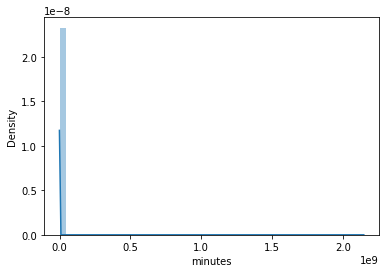

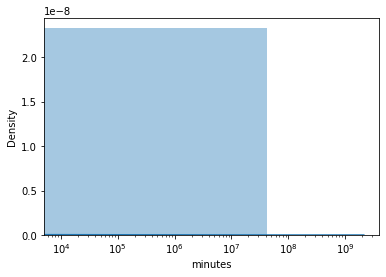

In [ ]:
minutes_check = RealityChecker(PP_RECIPES_DF, 'minutes') 
minutes_check.preform_check()


##### Detailed check #####

In [ ]:
minutes_check.check_range_portion(1, 180)

The range of 1 to 180 (inclusive) in the minutes column is 0.9202113651964065 of the records


0          55
1          30
2         130
3          45
6          15
         ... 
231632     60
231633      5
231634     40
231635     29
231636     20
Name: minutes, Length: 213155, dtype: int64
55
Reality Check For minutes Column
Description of Column:
count    213155.000000
mean         43.224930
std          32.656194
min           1.000000
25%          20.000000
50%          35.000000
75%          60.000000
max         180.000000
Name: minutes, dtype: float64

 There Are 176 unique values. Their Frequency list:
30     18391
20     14822
40     13772
25     13204
35     12385
       ...  
157        2
178        2
167        1
169        1
148        1
Name: minutes, Length: 176, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


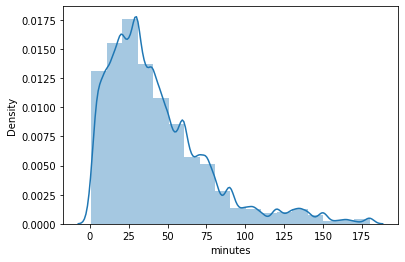

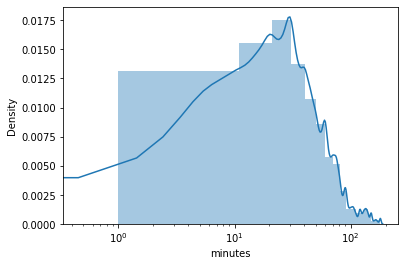

In [ ]:
main_range_minutes_check = RealityChecker(PP_RECIPES_DF.loc[(PP_RECIPES_DF["minutes"] >= 1) & (PP_RECIPES_DF["minutes"] <= 180)], 'minutes') 
main_range_minutes_check.preform_check(bins=18)

The range of 180 to 2000 (inclusive) in the minutes column is 0.07482828736341776 of the records
4          190
11        1460
12        2970
13         525
15         500
          ... 
231573    2895
231603     290
231614     195
231617     240
231622     210
Name: minutes, Length: 17388, dtype: int64
190
Reality Check For minutes Column
Description of Column:
count    1.738800e+04
mean     1.246743e+05
std      1.628564e+07
min      1.810000e+02
25%      2.400000e+02
50%      3.650000e+02
75%      5.000000e+02
max      2.147484e+09
Name: minutes, dtype: float64

 There Are 711 unique values. Their Frequency list:
195      754
190      689
200      640
210      613
250      575
        ... 
26100      1
9740       1
1640       1
87842      1
53290      1
Name: minutes, Length: 711, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


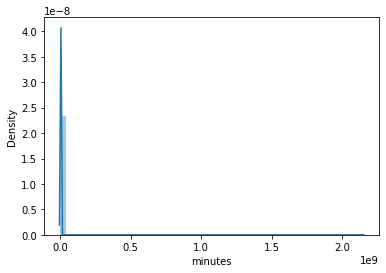

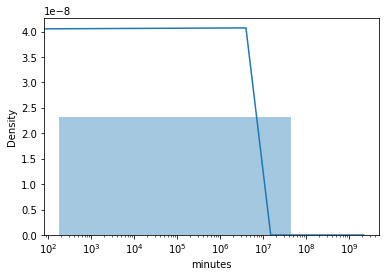

In [ ]:
minutes_check.check_range_portion(180, 2000)

large_values_minutes_check = RealityChecker(PP_RECIPES_DF.loc[(PP_RECIPES_DF["minutes"] >= 181)], 'minutes') 
large_values_minutes_check.preform_check()



1.  The **main range is 1-180** (30 mins jumps), can also try 20&40 to see that it doesnt change alot. this is 92% of the records
2.   **the high edge** case we will check is **181-2000 or above 180** (7.5% of the records)
3. **records with 0 *** are probably auto completed. these are only 0.4% of the records so no harm in **ignoring** them.



#### Steps Number Reality Check ####

###### Basic Check

0         11
1          9
2          6
3         11
4          5
          ..
231632     7
231633     1
231634     7
231635     9
231636     5
Name: n_steps, Length: 231637, dtype: int64
11
Reality Check For n_steps Column
Description of Column:
count    231637.000000
mean          9.765499
std           5.995128
min           0.000000
25%           6.000000
50%           9.000000
75%          12.000000
max         145.000000
Name: n_steps, dtype: float64

 There Are 94 unique values. Their Frequency list:
7     20785
8     19980
6     19927
9     18265
5     18047
      ...  
77        1
75        1
72        1
71        1
0         1
Name: n_steps, Length: 94, dtype: int64


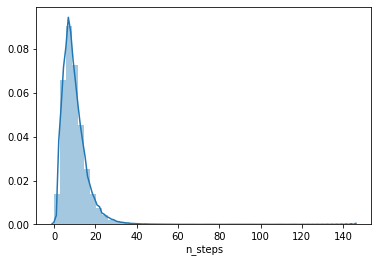

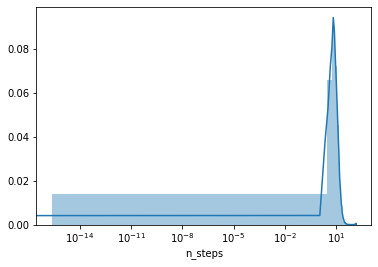

In [ ]:
n_steps_check = RealityChecker(PP_RECIPES_DF, 'n_steps')
n_steps_check.preform_check()

###### Detailed Check #####


In [ ]:
n_steps_check.check_range_portion(1, 25)
n_steps_check.check_range_portion(0, 0)
n_steps_check.check_range_portion(41, 200)



The range of 1 to 25 (inclusive) in the n_steps column is 0.9786389911801655 of the records
The range of 0 to 0 (inclusive) in the n_steps column is 4.317099599804867e-06 of the records
The range of 41 to 200 (inclusive) in the n_steps column is 0.002365770580693067 of the records


In [ ]:
PP_RECIPES_DF.loc[(PP_RECIPES_DF["n_steps"] == 0)]

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,cuisine_tags,cuisine_tags_num,fish_tags,fish_tags_num,seafood_tags,seafood_tags_num,fruit_tags,fruit_tags_num,cheese_eggs_tags,cheese_eggs_tags_num,grains_tags,grains_tags_num,lentils_tags,lentils_tags_num,meat_tags,meat_tags_num,vegetable_tags,vegetable_tags_num,is_vegan_tag,is_vegetarian_tags,nutrition_list,calories,total_fat_pdv,sugar_pdv,sodium_pdv,protein_pdv,saturated_fat_pdv,carbohydrates_pdv
3381,all season bread,176767,90,331268,2006-07-10,"['vegetables', 'for-large-groups', 'fruit', 's...","[198.8, 11.0, 70.0, 18.0, 5.0, 5.0, 10.0]",0,[],just change the fruit/vegetable in this recipe...,"['flour', 'baking soda', 'salt', 'baking powde...",12,['north-american'],1,[],0,[],0,"['bananas', 'fruit', 'tropical-fruit']",3,[],0,[],0,[],0,[],0,"['carrots', 'vegetables']",2,False,False,"[198.8, 11.0, 70.0, 18.0, 5.0, 5.0, 10.0]",198.8,11.0,70.0,18.0,5.0,5.0,10.0


In [ ]:
print("There are {0} recipes with at least 70 steps".format(len(PP_RECIPES_DF.loc[(PP_RECIPES_DF["n_steps"] >= 70)])))
print(" here are their steps: \n")
PP_RECIPES_DF.loc[(PP_RECIPES_DF["n_steps"] >= 70)]["steps"].tolist()

There are 35 recipes with at least 70 steps
 here are their steps: 



["['roast garlic: place oven rack on second notch', 'turn oven to 375 degrees f', 'cut tops off of the heads of garlic and discard excess skin', 'place garlic on a sheet of aluminum foil and drizzle 1 tsp olive oil over the tops', 'fold up edges of foil and add 2 tsp white wine to the bottom', 'seal packet tightly and place in oven', 'bake 40-45 minutes or until garlic is tender when pierced', 'open packet carefully to let cool and set aside', 'roast asparagus: turn up heat to 400 degrees f', 'holding at the end , gently bend each asparagus spear and snap off where it gives naturally', 'discard ends', 'pare leaves from stalks , leaving the', 'soak asparagus in cold water for 10 minutes', 'spray two cookie sheets with cooking spray', 'rinse asparagus twice and drain', 'blot dry with paper towels', 'place in a large bowl', 'drizzle 2 tbsp olive oil over asparagus , then sprinkle with garlic salt and pepper', 'toss to coat', 'remove asparagus , letting excess oil drip back into the bowl ,

0         11
1          9
2          6
3         11
4          5
          ..
231632     7
231633     1
231634     7
231635     9
231636     5
Name: n_steps, Length: 226689, dtype: int64
11
Reality Check For n_steps Column
Description of Column:
count    226689.000000
mean          9.274310
std           4.894477
min           1.000000
25%           6.000000
50%           8.000000
75%          12.000000
max          25.000000
Name: n_steps, dtype: float64

 There Are 25 unique values. Their Frequency list:
7     20785
8     19980
6     19927
9     18265
5     18047
10    16272
4     14753
11    14131
12    11940
3     11461
13    10137
14     8297
2      6982
15     6759
16     5522
17     4640
18     3621
19     3184
20     2468
1      2442
21     2005
22     1683
23     1334
24     1128
25      926
Name: n_steps, dtype: int64


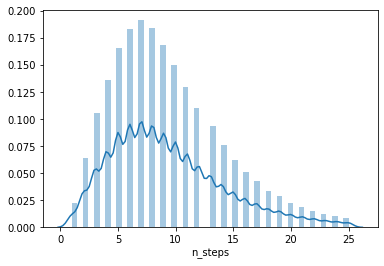

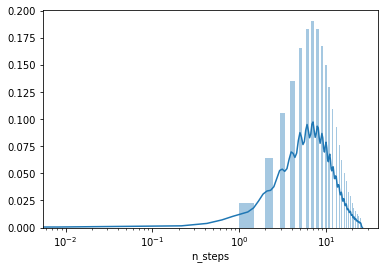

In [ ]:
main_range_n_steps_check = RealityChecker(PP_RECIPES_DF.loc[(PP_RECIPES_DF["n_steps"] >= 1) & (PP_RECIPES_DF["n_steps"] <= 25)], 'n_steps') 
main_range_n_steps_check.preform_check()

64        26
69        41
162       38
207       39
279       27
          ..
231506    31
231541    28
231591    36
231610    82
231627    38
Name: n_steps, Length: 4947, dtype: int64
26
Reality Check For n_steps Column
Description of Column:
count    4947.000000
mean       32.275521
std         8.210305
min        26.000000
25%        27.000000
50%        30.000000
75%        34.000000
max       145.000000
Name: n_steps, dtype: float64

 There Are 68 unique values. Their Frequency list:
26     791
27     654
28     545
29     428
30     364
      ... 
98       1
110      1
71       1
75       1
97       1
Name: n_steps, Length: 68, dtype: int64


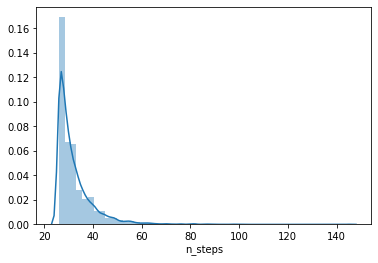

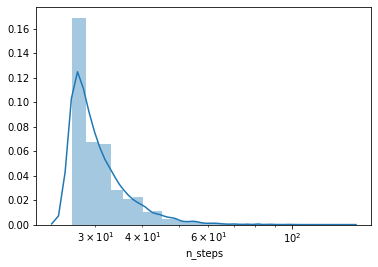

In [ ]:
edge_range_n_steps_check = RealityChecker(PP_RECIPES_DF.loc[(PP_RECIPES_DF["n_steps"] >= 26)], 'n_steps') 
edge_range_n_steps_check.preform_check()



1.  The **main range is 1-25** 5 steps jumps), can also try 3&7 to see that it doesnt change alot. this is 98% of the records
2.   **the high edge** case we will check is **26 and beyond** (almost all the rest)
3. **one redcord with 0 *** are probably auto completed. these are only one of the records so no harm in **ignoring** it.

there are 35 records with 70 or more steps. from looking at it it seems like long recipes but the number of steps is mainly due to the creators divide it more than most of people do





#### Number of Ingredients Reality Check ####

###### Basic Check

0          7
1          6
2         13
3         11
4          8
          ..
231632    22
231633    13
231634     8
231635    10
231636     7
Name: n_ingredients, Length: 231637, dtype: int64
7
Reality Check For n_ingredients Column
Description of Column:
count    231637.000000
mean          9.051153
std           3.734796
min           1.000000
25%           6.000000
50%           9.000000
75%          11.000000
max          43.000000
Name: n_ingredients, dtype: float64

 There Are 41 unique values. Their Frequency list:
8     25532
9     24599
7     24599
10    22430
6     21840
11    19094
5     18217
12    15165
4     12650
13    11640
14     8284
3      6800
15     6014
16     4145
17     2793
2      2127
18     1913
19     1279
20      852
21      529
22      346
23      244
24      178
25      107
26       68
27       55
28       33
1        25
29       22
30       20
31       13
32        5
33        4
35        4
34        3
40        2
37        2
36        1
38        1
39 

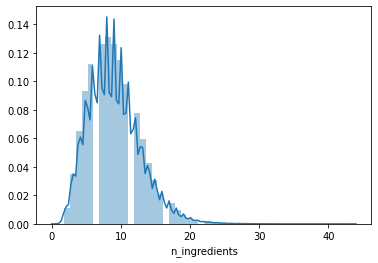

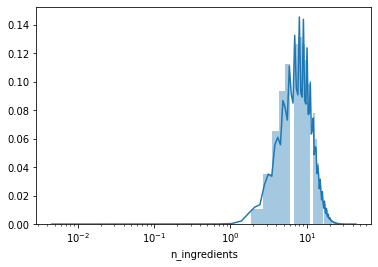

In [ ]:
n_ingredients_check = RealityChecker(PP_RECIPES_DF, 'n_ingredients')
n_ingredients_check.preform_check()

##### Detailed Check #####

In [ ]:
n_ingredients_check.check_range_portion(1, 20)
n_ingredients_check.check_range_portion(21, 43)




The range of 1 to 20 (inclusive) in the n_ingredients column is 0.9929242737559199 of the records
The range of 21 to 43 (inclusive) in the n_ingredients column is 0.007075726244080177 of the records


0          7
1          6
2         13
3         11
4          8
          ..
231631    11
231633    13
231634     8
231635    10
231636     7
Name: n_ingredients, Length: 229998, dtype: int64
7
Reality Check For n_ingredients Column
Description of Column:
count    229998.000000
mean          8.950687
std           3.545511
min           1.000000
25%           6.000000
50%           9.000000
75%          11.000000
max          20.000000
Name: n_ingredients, dtype: float64

 There Are 20 unique values. Their Frequency list:
8     25532
9     24599
7     24599
10    22430
6     21840
11    19094
5     18217
12    15165
4     12650
13    11640
14     8284
3      6800
15     6014
16     4145
17     2793
2      2127
18     1913
19     1279
20      852
1        25
Name: n_ingredients, dtype: int64


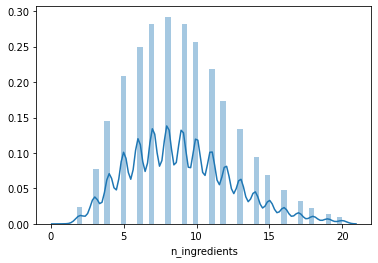

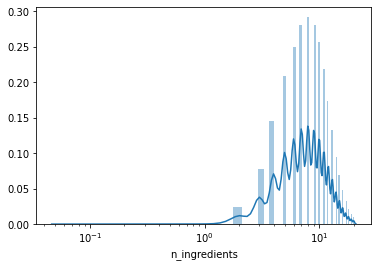

In [ ]:
main_range_n_ingredients_check = RealityChecker(PP_RECIPES_DF.loc[(PP_RECIPES_DF["n_ingredients"] >= 1) & (PP_RECIPES_DF["n_ingredients"] <= 20)], 'n_ingredients') 
main_range_n_ingredients_check.preform_check()

7         22
41        21
69        22
132       22
215       23
          ..
230643    21
231333    22
231585    21
231587    29
231632    22
Name: n_ingredients, Length: 1639, dtype: int64
22
Reality Check For n_ingredients Column
Description of Column:
count    1639.000000
mean       23.149481
std         2.674482
min        21.000000
25%        21.000000
50%        22.000000
75%        24.000000
max        43.000000
Name: n_ingredients, dtype: float64

 There Are 21 unique values. Their Frequency list:
21    529
22    346
23    244
24    178
25    107
26     68
27     55
28     33
29     22
30     20
31     13
32      5
33      4
35      4
34      3
40      2
37      2
36      1
38      1
39      1
43      1
Name: n_ingredients, dtype: int64


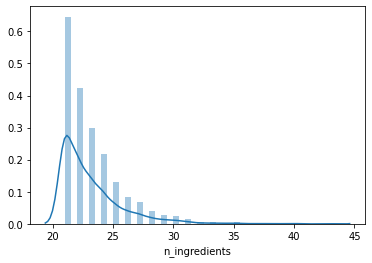

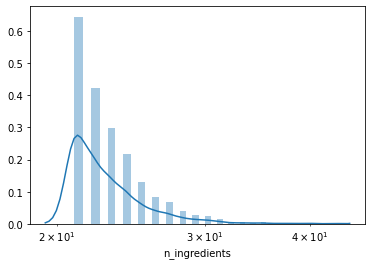

In [ ]:
edge_range_n_ingredients_check = RealityChecker(PP_RECIPES_DF.loc[(PP_RECIPES_DF["n_ingredients"] >= 21)], 'n_ingredients') 
edge_range_n_ingredients_check.preform_check()

1.  The **main range is 1-20** (4 ingredients jumps), can also try 3&7 to see that it doesnt change alot. this is 99.2% of the records
2.   **the high edge** case we will check is **21 and beyond** ( all the rest)

the max is 43 which is reasonable for a very complicated recipe
no zeros in here